In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:

class FCFS_simulator:

  def __init__(self, sample_size, lambda_, mu_, seed=0):

    self.sample_size = sample_size
    random.seed(seed)
    self.arrival_time_generator = lambda: -math.log(random.random())/lambda_ # マルコフ過程(指数分布)に従う.
    self.service_time_generator = lambda: -math.log(random.random())/mu_     # 指数分布に従う.
    
  def simulate(self):

    t = 0                                   # 現在時刻
    SS = 0                                  # 系内客数
    N_A = 0                                 # 到着客数
    N_D = 0                                 # 離脱客数
    t_A = self.arrival_time_generator()     # 次の到着時刻
    t_D = math.inf                          # 次の離脱時刻
    A = [0] * (self.sample_size+1)          # i番目の客の到着時刻を記録するための配列
    D = [0] * (self.sample_size+1)          # i番目の客の離脱時刻を記録するための配列
    while N_D != self.sample_size:
      if t_A <= t_D:                        # 次の事象が到着である場合
        t = t_A                             # 現在時刻を到着時刻t_Aに更新
        N_A = N_A + 1                       # 到着客数を1増やす
        if N_A <= self.sample_size:         # N_Aがsample数を超えていなければ, 時刻を記録
          A[N_A] = t
        SS = SS + 1                         # 系内客数を1増やす
        X = self.arrival_time_generator()   # 次の客の到着時間を生成
        t_A = t + X                         # 次の客の到着時刻を設定
        if SS == 1:                         # 系内客数が1であれば, t_D=infなので離脱時間を設定しておく必要がある
          Y = self.service_time_generator() # サービス時間を生成
          t_D = t + Y                       # サービス時間を設定

      elif t_A > t_D:                       # 次の事象が離脱である場合
        t = t_D                             # 現在時刻を到着時刻t_Dに更新
        N_D = N_D + 1                       # 離脱客数を1増やす
        D[N_D] = t                          # N_D番目の客の現在時刻を記録
        SS = SS - 1                         # 系内客数を1減らす

        if SS > 0:                          # 系内客数が0より大きい場合,
          Y = self.service_time_generator() # 現在先頭にいる客の離脱時刻を設定する必要がある
          t_D = t + Y
        elif SS == 0:                       # 系内客数が0の場合
          t_D = math.inf                    # 離脱時刻を設定する必要がないためinfに設定

    # シミュレーション結果から平均滞在時間を求める(P.60)
    mean_sojourn_time = 0

    for i in range(1,self.sample_size+1):
      mean_sojourn_time += D[i] - A[i]
    mean_sojourn_time /= self.sample_size

    return mean_sojourn_time


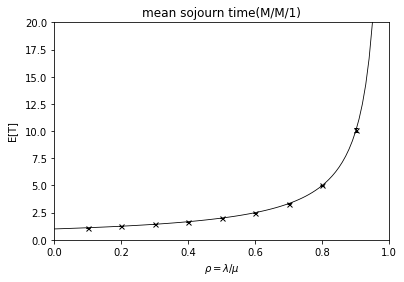

In [3]:

if __name__ == "__main__":

  # シミュレーションに関する定数の設定
  customer_size = 100000       # 1シミュレーションで扱う客数の数
  sample_size = 51           # 標本数
  
  x1 = []
  y1 = []
  confidence_interval = []

  for rho in np.arange(0.1, 1.0, 0.1):
    average_arrival_rate = rho # 平均到着率(λ)
    average_service_rate = 1.0 # 平均サービス率(μ)

    # trialsの数だけシミュレーションを行う
    result = [] # 各シミュレーションでの平均滞在時間を管理する
    for _ in range(sample_size):
      model = FCFS_simulator(sample_size=customer_size, lambda_=average_arrival_rate, mu_=average_service_rate, seed=random.randint(1, 100000000))
      mean_sojourn_time = model.simulate()
      result.append(mean_sojourn_time)

    # 信頼区間の計算(P.78)
    result = np.array(result)
    sample_mean = np.mean(result)
    sample_std = np.std(result, ddof=1) # 自由度n-1で割る
    # t = 2.228
    # t = 2.086
    t = 2.009 # 信頼水準が97.5, 自由度(= sample_size-1)が50のとき

    x1.append(rho)
    y1.append(sample_mean)
    confidence_interval.append(t*sample_std/math.sqrt(sample_size))

  # シミュレーション結果の描画
  g = plt.errorbar(x1, y1, yerr=confidence_interval, elinewidth=0.8, ecolor='black', markersize=5, fmt='xk', capsize=2)
  g[-1][0].set_linestyle('-') # 信頼区間のlinestyleの設定

  # 平均滞在時間の理論値(リトルの公式から)の描画
  x2 = np.arange(0, 1, 0.01)
  y2 = 1 / (1 - x2) # ¥mu = 1のとき, E[T] = 1 / ¥mu * 1/(1-¥rho) = 1 / (1 - ¥rho)
  plt.plot(x2, y2, linestyle='-', linewidth=0.8, color='black')
  
  plt.xlim(0, 1)
  plt.ylim(0, 20)
  
  plt.title('mean sojourn time(M/M/1)')
  plt.xlabel(r'$\rho=\lambda/\mu$')
  plt.ylabel(r'$\rm{E}[\rm{T}]$')
  plt.show()
